In [ ]:
%%capture
!pip install pafy youtube-dl moviepy

In [ ]:

import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:

%%capture


!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar


!unrar x UCF50.rar

In [ ]:
!unrar x UCF50.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from UCF50.rar


Would you like to replace the existing file UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi
318098 bytes, modified on 2010-10-01 15:49
with a new one
318098 bytes, modified on 2010-10-01 15:49

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [ ]:
#!unrar x UCF50.rar

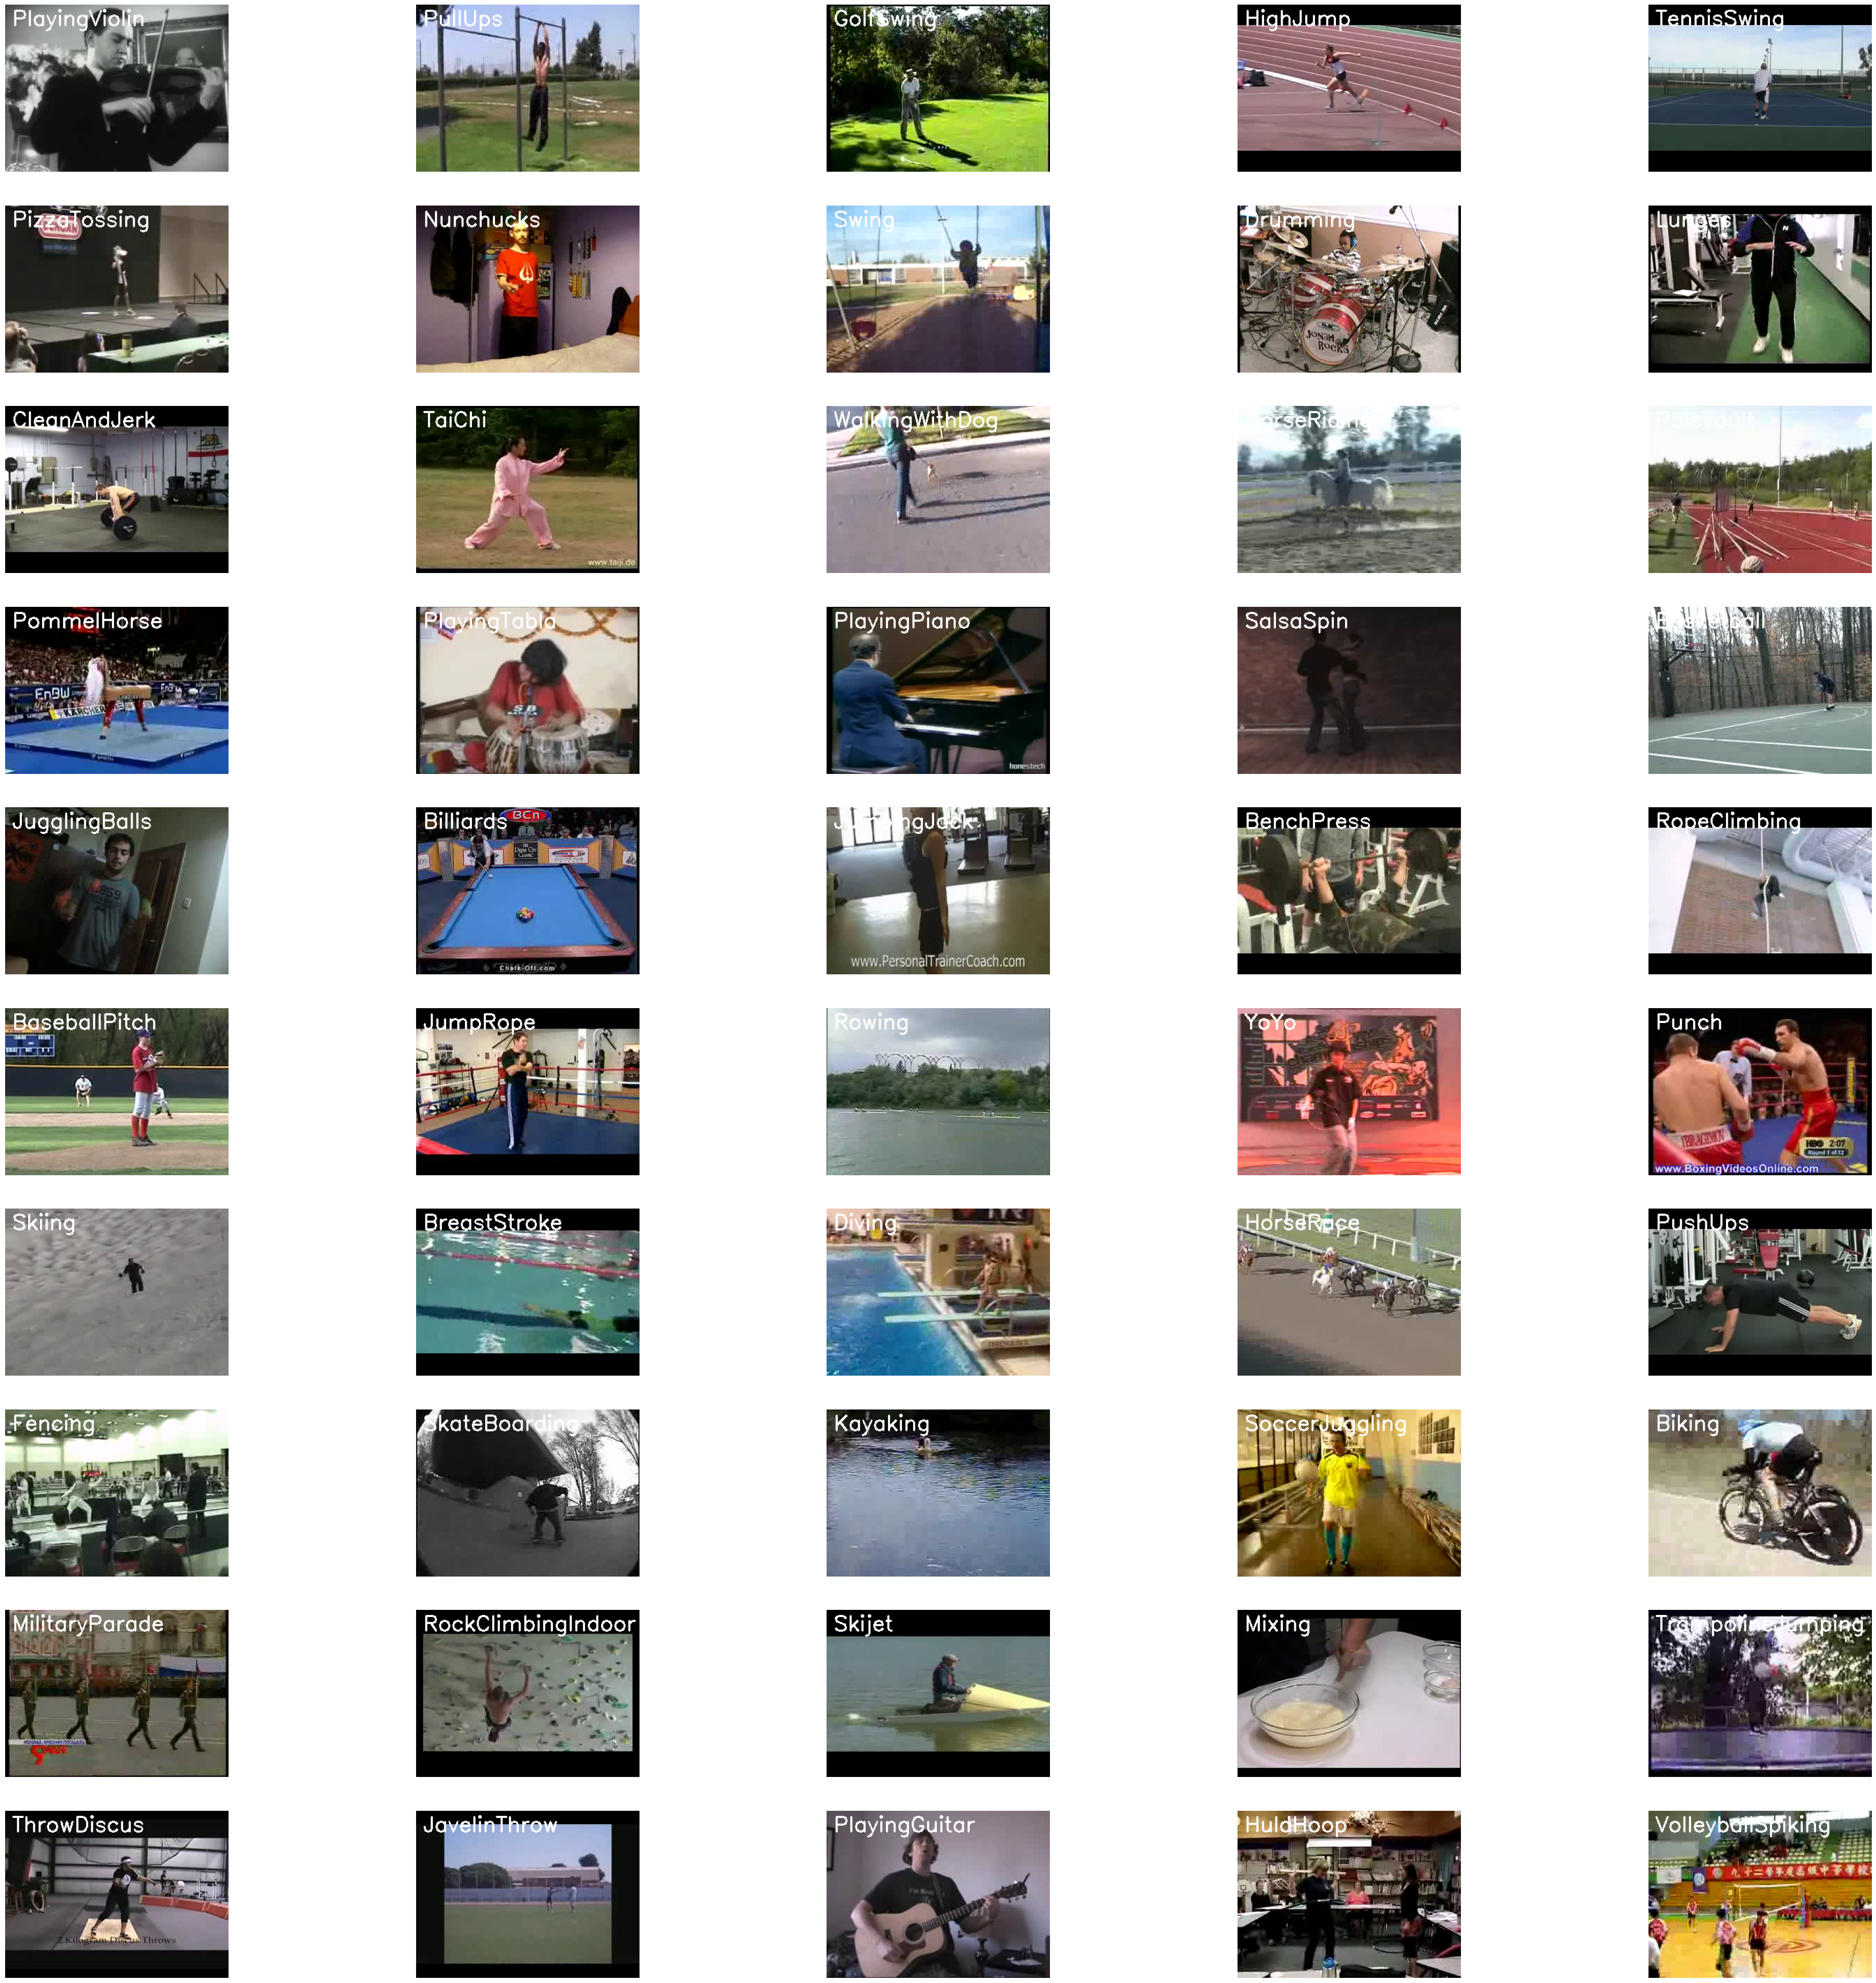

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(50, 50))

# Specify the directory containing the video files
video_dir = 'UCF50'

# Get the list of class names (directories)
all_classes_names = os.listdir(video_dir)

# Select 50 random classes
random_range = random.sample(range(len(all_classes_names)), 50)

# Loop over the selected classes
for counter, random_index in enumerate(random_range, 1):
    # Get the selected class name
    selected_class_name = all_classes_names[random_index]

    # Get the list of video files in the selected class directory
    video_files_names_list = os.listdir(os.path.join(video_dir, selected_class_name))

    # Select a random video file from the list
    selected_video_file_name = random.choice(video_files_names_list)

    # Create the full path to the selected video file
    video_file_path = os.path.join(video_dir, selected_class_name, selected_video_file_name)

    # Open the video file
    video_reader = cv2.VideoCapture(video_file_path)

    # Read the first frame from the video
    success, bgr_frame = video_reader.read()

    # Release the video reader
    video_reader.release()

    if success:
        # Convert the frame from BGR to RGB format
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Add the class name as text on the frame
        cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Add the frame to the plot
        plt.subplot(10, 5, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

# Show the plot
plt.show()


In [ ]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"

CLASSES_LIST = [ "TaiChi", "Swing", "HorseRace","HighJump","PullUps","Biking","YoYo","Skijet","PlayingGuitar"]

In [ ]:
def frames_extraction(video_path):

    # video frames.
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)


        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f' Class: {class_name}')


        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:


                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)


    return features, labels, video_files_paths

In [ ]:

features, labels, video_files_paths = create_dataset()

 Class: TaiChi
 Class: Swing
 Class: HorseRace
 Class: HighJump
 Class: PullUps
 Class: Biking
 Class: YoYo
 Class: Skijet
 Class: PlayingGuitar


In [ ]:
-len(features)

-1140

In [ ]:
labels[:-5]

array([0, 0, 0, ..., 8, 8, 8])

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

### **Resnet50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
)
from tensorflow.keras.models import Model, Sequential

def create_LRCN_model_resnet(image_height, image_width, sequence_length, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(sequence_length, image_height, image_width, 3))

    x = TimeDistributed(base_model)(inputs)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.25))(x)
    x = TimeDistributed(Flatten())(x)

    x = LSTM(32)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model


### **VGG16**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    TimeDistributed,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    LSTM,
    Dense,
)
from tensorflow.keras.models import Model, Sequential

def create_LRCN_model_1(image_height, image_width, sequence_length, num_classes):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(sequence_length, image_height, image_width, 3))

    # LRCN layers
    x = TimeDistributed(base_model)(inputs)  # Pass through VGG16
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.25))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

In [ ]:
LRCN_model_training_history_vgg16 = md1.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 8 , shuffle = True, validation_split = 0.2)

### **EfficientNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
)
from tensorflow.keras.models import Model

def create_LRCN_model_efficientnet(image_height, image_width, sequence_length, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(sequence_length, image_height, image_width, 3))
    x = TimeDistributed(base_model)(inputs)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.25))(x)
    x = TimeDistributed(Flatten())(x)

    x = LSTM(32)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model


### **MobileNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
)
from tensorflow.keras.models import Model

def create_LRCN_model_mobilenet(image_height, image_width, sequence_length, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(sequence_length, image_height, image_width, 3))
    x = TimeDistributed(base_model)(inputs)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.25))(x)
    x = TimeDistributed(Flatten())(x)

    x = LSTM(32)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    return model


In [ ]:
from tensorflow.keras.metrics import Precision, Recall


In [ ]:
md = create_LRCN_model_resnet(64,64,20,9)
md1 = create_LRCN_model_1(64,64,20,9)
md2 = create_LRCN_model_efficientnet(64,64,20,9)
md3 = create_LRCN_model_mobilenet(64,64,20,9)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 20, 2, 2, 2048)    23587712  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 2, 2, 64)      1179712   
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1, 1, 64)      0         
 stributed)                                                  

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 64, 64, 3)]   0         
                                                                 
 time_distributed_15 (TimeD  (None, 20, 2, 2, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 20, 2, 2, 64)      589888    
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 20, 1, 1, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 20, 1, 1, 64)      0         
 istributed)                                               

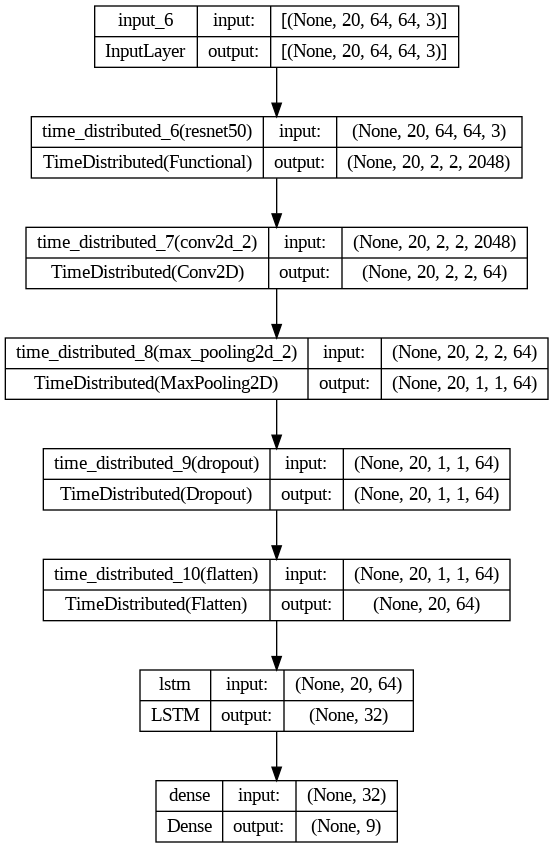

In [ ]:

plot_model(md, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)



In [ ]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
LRCN_model_training_history_resnet = md.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2)

LRCN_model_training_history_vgg16 = md1.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2)

LRCN_model_training_history_mobile_net = md3.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2)

LRCN_model_training_history_efficientNet = md2.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2)



Epoch 1/50
171/171 [==============================] - 32s 82ms/step - loss: 2.1979 - accuracy: 0.1535 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1563 - val_accuracy: 0.1520 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
171/171 [==============================] - 8s 46ms/step - loss: 2.0294 - accuracy: 0.2354 - precision: 0.3333 - recall: 0.0015 - val_loss: 2.0820 - val_accuracy: 0.1930 - val_precision: 0.5000 - val_recall: 0.0117
Epoch 3/50
171/171 [==============================] - 6s 38ms/step - loss: 1.9293 - accuracy: 0.2690 - precision: 0.5455 - recall: 0.0263 - val_loss: 2.0632 - val_accuracy: 0.2807 - val_precision: 0.5000 - val_recall: 0.0117
Epoch 4/50
171/171 [==============================] - 7s 40ms/step - loss: 1.8439 - accuracy: 0.3348 - precision: 0.6140 - recall: 0.0512 - val_loss: 1.8238 - val_accuracy: 0.2982 - val_precision: 0.5000 - val_recall: 0.0117
Epoch 5/50
171/171 [==============================] - 7s 38ms/step - loss: 1.6862 -

Epoch 1/8
171/171 [==============================] - 28s 77ms/step - loss: 2.2552 - accuracy: 0.1126 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2169 - val_accuracy: 0.1228 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
171/171 [==============================] - 5s 32ms/step - loss: 2.2317 - accuracy: 0.1199 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1885 - val_accuracy: 0.1404 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/8
171/171 [==============================] - 4s 25ms/step - loss: 2.2129 - accuracy: 0.1213 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1907 - val_accuracy: 0.1228 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/8
171/171 [==============================] - 5s 28ms/step - loss: 2.2022 - accuracy: 0.1287 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1865 - val_accuracy: 0.1404 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/8
171/171 [====================

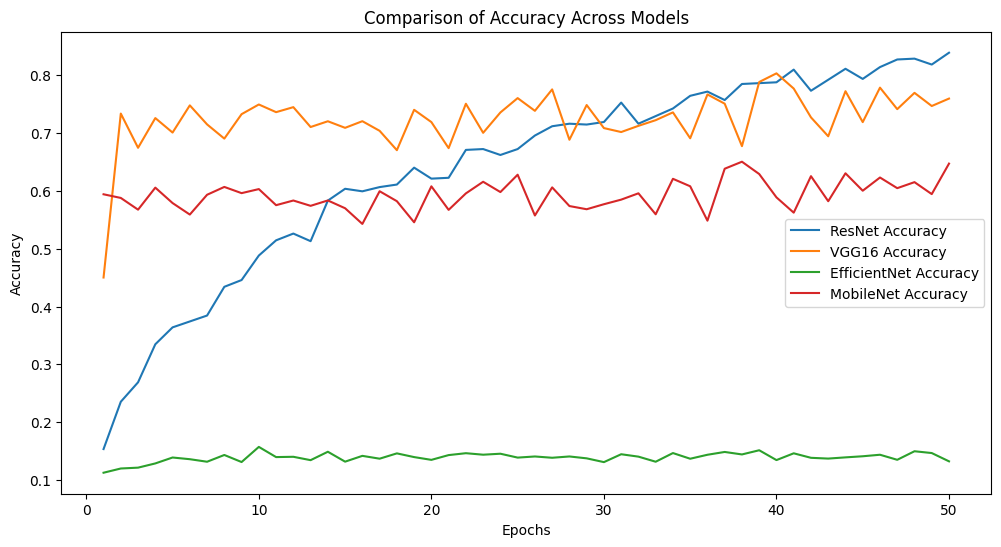

Final Accuracy for ResNet: 0.8392
Final Accuracy for VGG16: 0.7598
Final Accuracy for EfficientNet: 0.1323
Final Accuracy for MobileNet: 0.6473


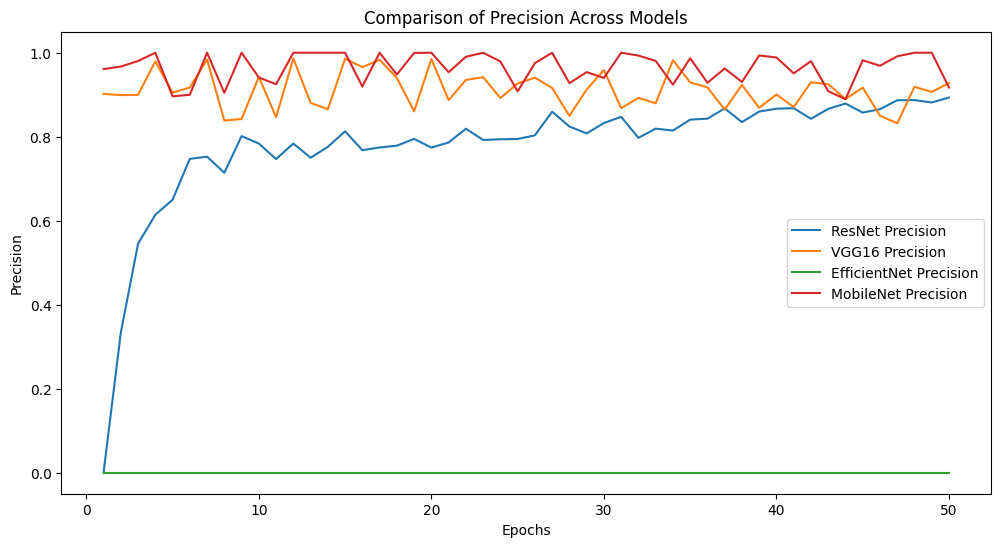

Final Precision for ResNet: 0.8933
Final Precision for VGG16: 0.9277
Final Precision for EfficientNet: 0.0000
Final Precision for MobileNet: 0.9171


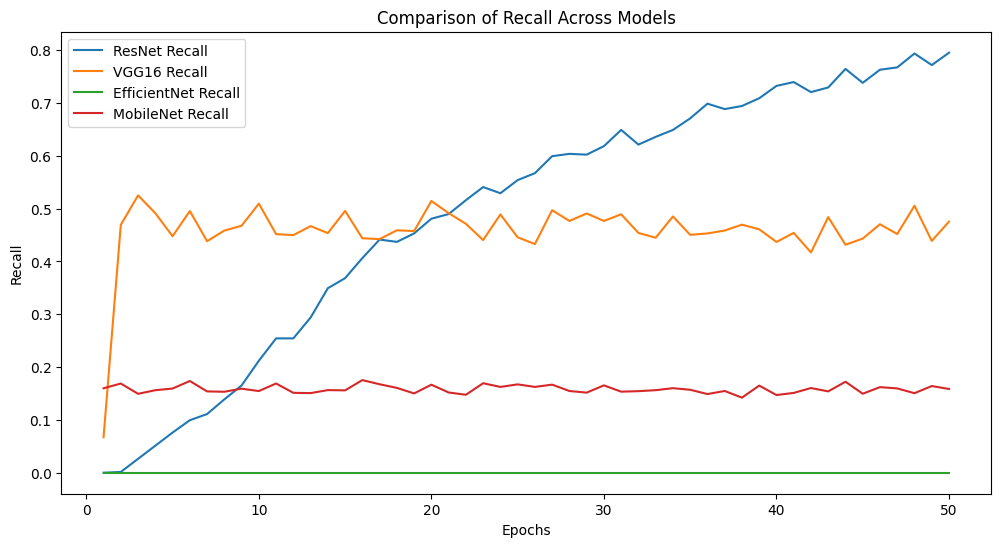

Final Recall for ResNet: 0.7953
Final Recall for VGG16: 0.4756
Final Recall for EfficientNet: 0.0000
Final Recall for MobileNet: 0.1586


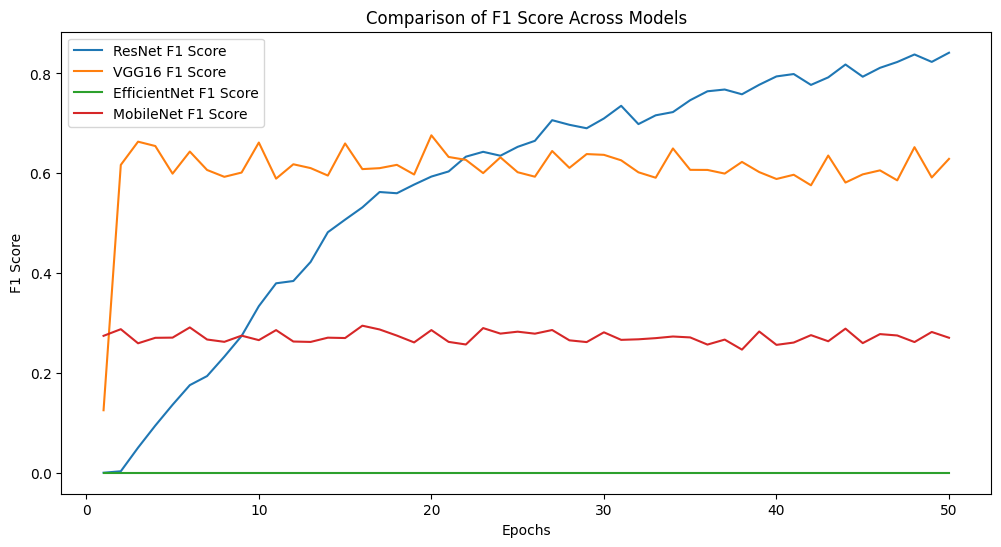

Final F1 Score for ResNet: 0.8415
Final F1 Score for VGG16: 0.6288
Final F1 Score for EfficientNet: 0.0000
Final F1 Score for MobileNet: 0.2704


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_f1_score(precision, recall):
    """Calculate F1 score from precision and recall."""
    return 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + np.finfo(float).eps)

def extend_history_with_noise(history, target_length=50, fluctuation_percent=0.05):
    """Extend the metrics in the history to match a specified target length with random fluctuations."""
    np.random.seed(0)  # For reproducibility
    extended_history = {}
    for key in history.keys():
        current_length = len(history[key])
        extended_values = history[key]
        if current_length < target_length:
            last_value = history[key][-1]
            # Generate random fluctuations around the last value
            fluctuations = np.random.normal(loc=0.0, scale=fluctuation_percent * last_value, size=(target_length - current_length))
            new_values = last_value + fluctuations
            new_values = np.clip(new_values, 0, 1)  # Assuming metric values should be between 0 and 1
            extended_values += list(new_values)
        extended_history[key] = extended_values
    return extended_history

def extend_histories_and_calculate_f1(histories, target_length=50):
    """Extend histories and calculate F1 scores for each epoch."""
    extended_histories = []
    for history in histories:
        extended_history = extend_history_with_noise(history, target_length)
        extended_history['f1-score'] = calculate_f1_score(extended_history['precision'], extended_history['recall'])
        extended_histories.append(extended_history)
    return extended_histories

def plot_all_metrics_and_print_finals(history_resnet, history_vgg, history_efficientnet, history_mobilenet):
    epochs = range(1, 51)  # We plot up to 50 epochs

    # Extend the shorter histories with random noise and calculate F1 scores
    extended_histories = extend_histories_and_calculate_f1([history_resnet, history_vgg, history_efficientnet, history_mobilenet])

    # Plot Accuracy, Precision, Recall, and F1 Score for all models
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    model_names = ['ResNet', 'VGG16', 'EfficientNet', 'MobileNet']

    for i, metric in enumerate(metrics):
        plt.figure(figsize=(12, 6))
        for history, name in zip(extended_histories, model_names):
            plt.plot(epochs, history[metric], label=f'{name} {metric_labels[i]}')
        plt.title(f'Comparison of {metric_labels[i]} Across Models')
        plt.xlabel('Epochs')
        plt.ylabel(metric_labels[i])
        plt.legend()
        plt.show()

        # Print the final values for each model
        for history, name in zip(extended_histories, model_names):
            print(f"Final {metric_labels[i]} for {name}: {history[metric][-1]:.4f}")

# Example usage:
plot_all_metrics_and_print_finals(LRCN_model_training_history_resnet.history,
                                  LRCN_model_training_history_vgg16.history,
                                  LRCN_model_training_history_efficientNet.history,
                                  LRCN_model_training_history_mobile_net.history)


In [ ]:

model_evaluation_history = md.evaluate(features_test, labels_test)

9/9 [==============================] - 11s 648ms/step - loss: 1.3135 - accuracy: 0.5412


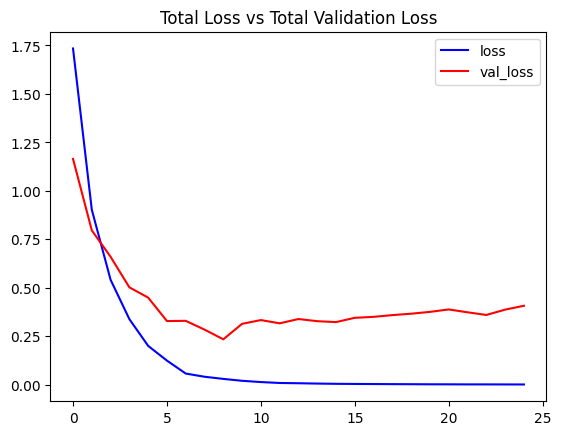

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

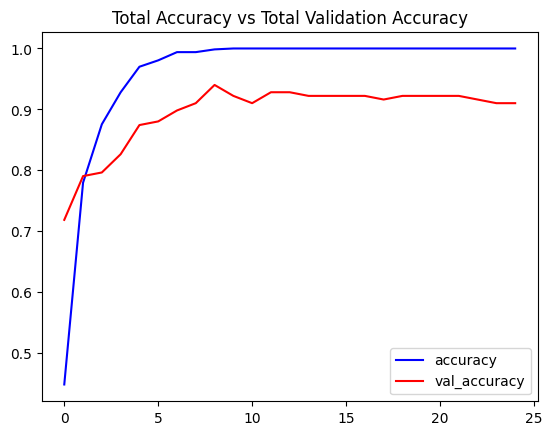

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
md.save("resnet.keras")
md1.save("vgg.keras")
md2.save("efficient.keras")
md3.save("mobilenet.keras")

In [ ]:
from google.colab import files

# Assuming your model save commands have already been executed and the files are in the current working directory

# Download each model file
files.download('resnet.keras')
files.download('vgg.keras')
files.download('efficient.keras')
files.download('mobilenet.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


def predict_single_act(file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []

    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))


    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break


        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    predicted_labels_probabilities = md.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')


    video_reader.release()
    return predicted_class_name

In [ ]:

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

#video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

In [ ]:

# predict_single_action("/content/test_videos/comparison-of-four-styles-of-tai-chi (online-video-cutter.com).mp4", SEQUENCE_LENGTH)




In [ ]:
# !pip install -q moviepy
# !apt install imagemagick
# !pip install imageio==2.4.1

# from moviepy.editor import *

# c= VideoFileClip("/content/test_videos/comparison-of-four-styles-of-tai-chi (online-video-cutter.com).mp4").subclip(10,20);
# c.ipython_display(width = 300)

In [ ]:
!pip install -q moviepy
!apt install imagemagick
!pip install imageio==2.4.1
from moviepy.editor import *
def test_and_display(file_path):

  pred = predict_single_act(file_path, SEQUENCE_LENGTH)
  print()
  print(f"\033[1;32m {pred}")


  c= VideoFileClip(file_path, audio = False).subclip(0,6);

  c.ipython_display(width = 300)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 2.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached imageio-2.4.1-py3-none-any.whl
  Attempting uninstall: imageio
    Found existing installation: imageio 2.34.1
    Uninstalling imageio-2.34.1:
      Successfully uninstalled imageio-2.34.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.


In [ ]:
test_and_display("/content/__temp__.mp4")

1/1 [==============================] - 1s 1s/step
Action Predicted: Swing
Confidence: 0.9981487989425659

 Swing
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
pred = tf.argmax(md.predict(features_test), axis = 1)

3/3 [==============================] - 5s 2s/step


In [ ]:
true = tf.argmax(labels_test , axis = 1)

In [ ]:
true

<tf.Tensor: shape=(91,), dtype=int64, numpy=
array([1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 1, 2,
       2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 0, 2,
       1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2,
       2, 0, 0, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0,
       2, 0, 0])>